In [100]:
import bw2analyzer as bwa
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import bw_processing as bwp
import pandas as pd
from bw2data.query import Filter, Query
import numpy as np
import scipy as sp
from pprint import pprint
from tqdm import autonotebook
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.collections as clt
from sklearn import cluster, mixture
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import math

In [49]:
#Importing the variables with the project name and background db
from project_details import ei_name, project_name

In [50]:
bd.projects.set_current(project_name)
bd.databases

Databases dictionary with 3 object(s):
	asphalt
	biosphere3
	ecoinvent-391-cutoff

In [51]:
# Is the background database name the same as the one we wrote in `project_details.py`?
assert ei_name in bd.databases

In [52]:
fg_name = "asphalt"

In [53]:
fgdb = bd.Database(fg_name)

## Uncertainty Characterization

In this example, we will be considering the transport distance of materials to the asphalt plant in A2, the transport distance of the asphalt mixture from the asphalt plant to the construction site in A4, and the diesel consumption of the machinery used for construction in A5 as uncertain parameters. The foreground file already provides uncertainty information for each of these parameters, let's extract it.

In [54]:
uncertain_parameters = []

### Transport distances in A2

In [55]:
materials = fgdb.search("production and transport")
materials

['bitumen, production and transport' (kilogram, NL, None),
 'crushed sand, production and transport' (kilogram, NL, None),
 'weak filler, production and transport' (kilogram, NL, None),
 'natural sand, production and transport' (kilogram, NL, None),
 'other fillers, production and transport' (kilogram, NL, None),
 'crushed stone, production and transport' (kilogram, NL, None),
 'drip resistant material, production and transport' (kilogram, NL, None)]

In [56]:
for material in materials:
    exchanges = material.technosphere()
    for exchange in exchanges:
        exchanges_dict = exchange.as_dict()
        if "comments" in exchanges_dict:
            parameter = exchanges_dict["comments"]
            distribution = exchanges_dict["uncertainty_type"]
            loc = exchanges_dict["loc"]
            scale = exchanges_dict["scale"]
            uncertain_parameters.append((parameter, 
                    distribution, 
                    loc,
                    scale))
uncertain_parameters

[('A2_bitumen_t', 2, -1.3862943611198906, 0.3474550330618338),
 ('A2_crushedsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedsand_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_weakfiller_t', 2, -1.995100393246085, 0.3474550330618338),
 ('A2_naturalsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_naturalsand_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_ownmaterial_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_ownmaterial_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedstone_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedstone_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_dripresistantmaterial_t', 2, -1.731605546408308, 0.3474550330618338)]

## Transport distances in A4

In [57]:
transport_a4 = fgdb.search("asphalt, transport to site")
transport_a4

['asphalt, transport to site' (kilogram, NL, None)]

In [58]:
for transport in transport_a4:
    exchanges = transport.technosphere()
    for exchange in exchanges:
        exchanges_dict = exchange.as_dict()
        if "comments" in exchanges_dict:
            parameter = exchanges_dict["comments"]
            distribution = exchanges_dict["uncertainty_type"]
            loc = exchanges_dict["loc"]
            scale = exchanges_dict["scale"]
            uncertain_parameters.append((parameter, 
                    distribution, 
                    loc,
                    scale))
uncertain_parameters

[('A2_bitumen_t', 2, -1.3862943611198906, 0.3474550330618338),
 ('A2_crushedsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedsand_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_weakfiller_t', 2, -1.995100393246085, 0.3474550330618338),
 ('A2_naturalsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_naturalsand_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_ownmaterial_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_ownmaterial_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedstone_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedstone_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_dripresistantmaterial_t', 2, -1.731605546408308, 0.3474550330618338),
 ('A4_distance_EURO5', 2, -3.402197881995739, 0.3474550330618338),
 ('A4_distance_EURO6', 2, -4.500810170663849, 0.3474550330618338)]

## Diesel consumption in A5

In [59]:
construction = fgdb.search("asphalt, construction")
construction

['asphalt, construction' (kilogram, NL, None)]

In [60]:
for consumption in construction:
    exchanges = consumption.technosphere()
    for exchange in exchanges:
        exchanges_dict = exchange.as_dict()
        if "comments" in exchanges_dict:
            parameter = exchanges_dict["comments"]
            distribution = exchanges_dict["uncertainty_type"]
            loc = exchanges_dict["loc"]
            scale = exchanges_dict["scale"]
            uncertain_parameters.append((parameter, 
                    distribution, 
                    loc,
                    scale))
uncertain_parameters

[('A2_bitumen_t', 2, -1.3862943611198906, 0.3474550330618338),
 ('A2_crushedsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedsand_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_weakfiller_t', 2, -1.995100393246085, 0.3474550330618338),
 ('A2_naturalsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_naturalsand_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_ownmaterial_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_ownmaterial_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedstone_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedstone_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_dripresistantmaterial_t', 2, -1.731605546408308, 0.3474550330618338),
 ('A4_distance_EURO5', 2, -3.402197881995739, 0.3474550330618338),
 ('A4_distance_EURO6', 2, -4.500810170663849, 0.3474550330618338),
 ('A5_construction', 2, -4.468892567695543, 0.03741657386773941)]

## Sample generation

Now that we have retrieved the uncertain parameters information, we can proceed to generate our samples.

First, we define a Latin hypercube sampling (LHS) function:

In [61]:
def LHS_generator(inputs, sample_size, seed=None):
    # Determine the number of parameters based on the length of inputs
    num_parameters = len(inputs)

    # Assign random seed (if specified) for reproducibility
    if seed:
        np.random.seed(seed)

    # Initialize an empty array to hold the results
    result = np.empty([sample_size, num_parameters])
    
    # Calculate the interval width for the uniform distribution
    d = 1.0 / sample_size
    
    # Generate samples using uniform distribution within specified ranges
    temp = np.array(
        [
            np.random.uniform(low=sample * d, high=(sample + 1) * d, size=num_parameters)
            for sample in range(sample_size)
        ]
    )

    # Process each parameter to perform Latin Hypercube Sampling for log-normal distribution
    for parameter in range(num_parameters):
        # Shuffle the samples to ensure randomness
        np.random.shuffle(temp[:, parameter])
        
        # Apply the inverse cumulative distribution function (ppf) of the normal distribution
        # then exponentiate to transform to a log-normal distribution
        temp[:, parameter] = np.exp(sp.stats.norm.ppf(temp[:, parameter], loc=inputs[parameter][2], scale=inputs[parameter][3]))
        
        # Fill the result array with processed samples
        for sample in range(sample_size):
            result[sample, parameter] = temp[sample, parameter]

    # Convert result to a DataFrame with column names from the first column of inputs
    column_names = [inputs[i][0] for i in range(num_parameters)]
    result_df = pd.DataFrame(result, columns=column_names)

    return result_df

In [62]:
samples = LHS_generator(uncertain_parameters,100)

In [63]:
samples

,A2_bitumen_t,A2_crushedsand_t,A2_crushedsand_iv,A2_weakfiller_t,A2_naturalsand_t,A2_naturalsand_iv,A2_ownmaterial_t,A2_ownmaterial_iv,A2_crushedstone_t,A2_crushedstone_iv,A2_dripresistantmaterial_t,A4_distance_EURO5,A4_distance_EURO6,A5_construction
0,0.252033,0.039997,0.300503,0.142086,0.024111,0.124573,0.024727,0.130057,0.021490,0.619959,0.171095,0.030469,0.007443,0.011051
1,0.286323,0.039385,0.806346,0.180798,0.023762,0.118797,0.047472,0.090435,0.020011,1.245152,0.187586,0.041368,0.006759,0.012194
2,0.248841,0.021889,0.576775,0.072687,0.018561,0.133245,0.043176,0.202462,0.026382,0.651251,0.158987,0.066921,0.014560,0.012072
3,0.184899,0.025427,0.645134,0.178552,0.040091,0.189755,0.025541,0.175794,0.032227,0.493239,0.122030,0.036699,0.007779,0.011327
4,0.255880,0.030343,0.598579,0.243835,0.030518,0.117813,0.037062,0.157442,0.024035,0.382358,0.332929,0.032898,0.009564,0.011901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.345317,0.023808,0.896529,0.081626,0.021878,0.193545,0.031639,0.095894,0.029158,0.587319,0.135885,0.061347,0.009795,0.011601
96,0.459869,0.031569,0.919024,0.122537,0.023412,0.106554,0.033711,0.141521,0.041720,0.500308,0.110251,0.029127,0.008620,0.011261
97,0.326892,0.052353,0.626548,0.130490,0.020383,0.097501,0.025747,0.170907,0.038593,0.453650,0.198169,0.043324,0.013915,0.012463
98,0.179244,0.047881,0.928014,0.223424,0.009841,0.136585,0.031110,0.188420,0.056809,0.999209,0.201487,0.045722,0.006226,0.011554


## Link samples to exchanges

In [64]:
def exchange_coords(exchange):
    """create a tuple with the numerical ids of the input and output activites of an exchange."""
    input_activity = bd.get_activity(exchange["input"])
    output_activity = bd.get_activity(exchange["output"])
    return (input_activity.id, output_activity.id)

In [65]:
def build_coords_sample(activities, samples_df):
    
    coords_samples_map = {}

    counter = 0

    for activity in activities:
        exchanges = activity.technosphere()
        for exchange in exchanges:
            exchanges_dict = exchange.as_dict()
            if "comments" in exchanges_dict:
                col_name = exchanges_dict["comments"]
                coords = exchange_coords(exchange)
                counter += 1
                print(f"{counter}. {exchange}\n\t 👉 {coords} to {col_name}")
                coords_samples_map[exchange_coords(exchange)] = samples_df[
                    col_name
                ].values  # numpy.ndarray
    return coords_samples_map


In [66]:
# Group activity variables
activities = materials + transport_a4 + construction
activities

['bitumen, production and transport' (kilogram, NL, None),
 'crushed sand, production and transport' (kilogram, NL, None),
 'weak filler, production and transport' (kilogram, NL, None),
 'natural sand, production and transport' (kilogram, NL, None),
 'other fillers, production and transport' (kilogram, NL, None),
 'crushed stone, production and transport' (kilogram, NL, None),
 'drip resistant material, production and transport' (kilogram, NL, None),
 'asphalt, transport to site' (kilogram, NL, None),
 'asphalt, construction' (kilogram, NL, None)]

In [67]:
coords_samples_map = build_coords_sample(activities, samples)

1. Exchange: 0.25 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'bitumen, production and transport' (kilogram, NL, None)>
	 👉 (18370, 25950) to A2_bitumen_t
2. Exchange: 0.025 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'crushed sand, production and transport' (kilogram, NL, None)>
	 👉 (18370, 25952) to A2_crushedsand_t
3. Exchange: 0.66 ton kilometer 'market for transport, freight, inland waterways, barge' (ton kilometer, RER, None) to 'crushed sand, production and transport' (kilogram, NL, None)>
	 👉 (9408, 25952) to A2_crushedsand_iv
4. Exchange: 0.136 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'weak filler, production and transport' (kilogram, NL, None)>
	 👉 (18370, 25955) to A2_weakfiller_t
5. Exchange: 0.025 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'natural sand, production

In [68]:
counter = 0
for k, v in coords_samples_map.items():
    counter +=1
    print(f"{counter}. {k} --array-> {v}")

1. (18370, 25950) --array-> [0.25203329 0.28632278 0.24884142 0.1848992  0.25588021 0.19014364
 0.40199082 0.21462145 0.49398857 0.19276101 0.2038167  0.43697167
 0.23866311 0.33432899 0.36346422 0.44710489 0.18745547 0.158644
 0.36461102 0.26109772 0.28524812 0.26583295 0.30103865 0.28133491
 0.17684628 0.27551068 0.27081952 0.19739221 0.2443815  0.19351698
 0.22944044 0.20429512 0.20925712 0.39422403 0.3298959  0.31087177
 0.28048549 0.20178353 0.138554   0.16736231 0.22141688 0.1547951
 0.14869544 0.2110919  0.37895311 0.20832993 0.15259878 0.17389368
 0.42739506 0.30585548 0.37250657 0.1289461  0.6731642  0.21351476
 0.35774762 0.31420317 0.32005256 0.26511798 0.14453178 0.41524353
 0.22746292 0.22435408 0.25677263 0.34035156 0.16486302 0.2697491
 0.26207682 0.2183899  0.38358074 0.17051554 0.30664937 0.13013122
 0.29079372 0.2930896  0.23205839 0.24129357 0.29954839 0.24755457
 0.11376696 0.22619403 0.31804353 0.24180138 0.16016133 0.35079074
 0.19852024 0.22001408 0.18387535 0.27

## Regular LCA from activity + method

In [69]:
pavement_structure = fgdb.get("pavement_structure")

In [70]:
cml_method_gwp = (
    "CML v4.8 2016",
    "climate change",
    "global warming potential (GWP100)",
)

In [71]:
a_lca = bc.LCA({pavement_structure: 1}, cml_method_gwp)

In [72]:
a_lca.lci()
a_lca.lcia()
a_lca.score

/Users/andreavargasf/anaconda3/envs/STI_environment/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.58e+13)
  warnings.warn(msg, UmfpackWarning)


1344776.4563756627

## LCA using datapackages

In [73]:
indexed_demand, data_objs, remapping_dicts = bd.prepare_lca_inputs(
    {pavement_structure: 1}, cml_method_gwp
)

In [74]:
indexed_demand

{25974: 1}

In [75]:
data_objs

In [76]:
dp_correlated = bwp.create_datapackage(sequential=True)

In [77]:
samples_indices = [coord for coord in coords_samples_map.keys()]
pprint(samples_indices)

[(18370, 25950),
 (18370, 25952),
 (9408, 25952),
 (18370, 25955),
 (18370, 25954),
 (9408, 25954),
 (18370, 25953),
 (9408, 25953),
 (18370, 25951),
 (9408, 25951),
 (18370, 25956),
 (16115, 25963),
 (8986, 25963),
 (18987, 25964)]


In [78]:
# Prepare the data_array, it must be an array of arrays
samples_values = np.array([coords_samples_map[coord] for coord in samples_indices])
pprint(samples_values)

array([[0.25203329, 0.28632278, 0.24884142, ..., 0.32689215, 0.17924361,
        0.33642836],
       [0.03999689, 0.03938452, 0.02188896, ..., 0.05235283, 0.04788122,
        0.01750107],
       [0.30050293, 0.80634611, 0.57677507, ..., 0.62654783, 0.92801419,
        0.88578305],
       ...,
       [0.0304692 , 0.04136763, 0.06692088, ..., 0.0433239 , 0.04572205,
        0.04515792],
       [0.00744282, 0.00675862, 0.01455954, ..., 0.01391532, 0.00622594,
        0.01386066],
       [0.01105062, 0.01219423, 0.01207215, ..., 0.01246304, 0.01155448,
        0.01109718]])


In [79]:
dp_correlated.add_persistent_array(
    matrix="technosphere_matrix",
    indices_array=np.array(samples_indices, dtype=bwp.INDICES_DTYPE),
    data_array=samples_values,
    # We flip the signs of the samples
    # to obey bw's convention
    flip_array=np.array([True for _ in range(len(samples_values))]),
)

## Build the new data objects to re-do the LCA

In [80]:
data_objs.append(dp_correlated)

In [81]:
dp_lca = bc.LCA(demand=indexed_demand, data_objs=data_objs, use_arrays=True)
dp_lca.lci()
dp_lca.lcia()
dp_lca.score

1306831.6447644534

In [82]:
scores = []
for _ in autonotebook.tqdm(range(100)):
    next(dp_lca)
    scores.append(dp_lca.score)

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
scores_a = np.array(scores)
scores_a.mean()

1366812.3179875815

In [84]:
scores_a_s = pd.Series(scores_a)
print(scores_a_s)

0     1.501353e+06
1     1.405665e+06
2     1.317941e+06
3     1.270298e+06
4     1.288826e+06
          ...     
95    1.316496e+06
96    1.324120e+06
97    1.467581e+06
98    1.321793e+06
99    1.306832e+06
Length: 100, dtype: float64


## Graph results

/var/folders/3t/9brqw33j6sl67t5_crw95f6h0000gn/T/ipykernel_65479/4067838399.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='GWP', inner=None, cut=0, bw=0.2, scale='width', orient='h', split=True)
/var/folders/3t/9brqw33j6sl67t5_crw95f6h0000gn/T/ipykernel_65479/4067838399.py:11: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=df, x='GWP', inner=None, cut=0, bw=0.2, scale='width', orient='h', split=True)


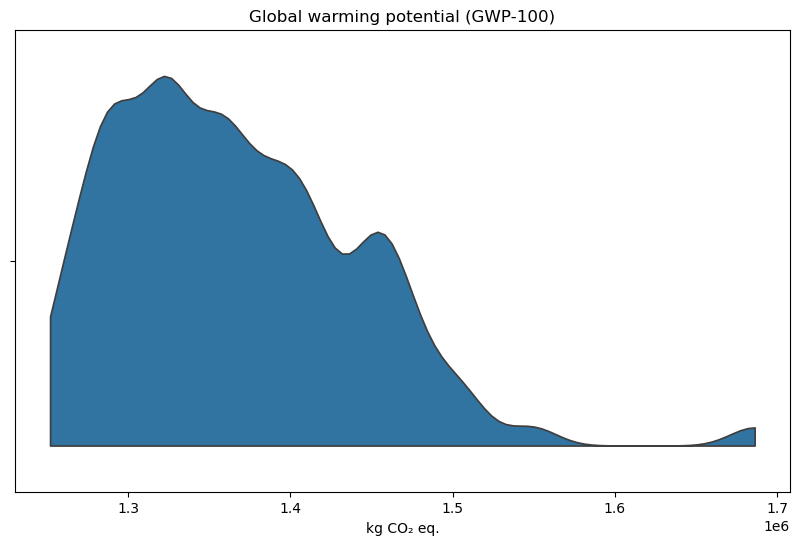

In [94]:
# Sample data as given in the series
data = scores_a_s

# Create a DataFrame from the series
df = pd.DataFrame(data, columns=['GWP'])

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the half violin plot (right side)
sns.violinplot(data=df, x='GWP', inner=None, cut=0, bw=0.2, scale='width', orient='h', split=True)

# Set the title and labels
plt.title("Global warming potential (GWP-100)")
plt.xlabel("kg CO₂ eq.")  # CO₂ with subscript '2'

# Show the plot
plt.show()

## Sensitivity analysis

In [108]:
x = samples.to_numpy()
y = scores_a_s.to_numpy()

#ExtraTrees parameters from Jaza-Roxen and Kwakkel (2018)
t = 100
m = round(len(x[0])/3)
N = 100
nmin = 5
nleaf = math.sqrt(N) / math.sqrt(1000)

#ExtraTrees regressor function
regr = ExtraTreesRegressor(n_estimators=t, max_features=m, min_samples_split=nmin,
                           min_samples_leaf=nleaf)
regr = regr.fit(x,y)

In [116]:
mdi = regr.feature_importances_
mdi = pd.DataFrame(mdi, columns=["MDI"])
mdi.index = samples.columns
mdi["MDI_norm"] = mdi["MDI"]/np.max(mdi["MDI"])
mdi

,MDI,MDI_norm
A2_bitumen_t,0.106142,0.990658
A2_crushedsand_t,0.017857,0.166667
A2_crushedsand_iv,0.089286,0.833333
A2_weakfiller_t,0.089286,0.833333
A2_naturalsand_t,0.089286,0.833333
A2_naturalsand_iv,0.089286,0.833333
A2_ownmaterial_t,0.035714,0.333333
A2_ownmaterial_iv,0.089286,0.833333
A2_crushedstone_t,0.107143,1.000000
A2_crushedstone_iv,0.035714,0.333333
